## Startup

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, coint
from statsmodels.tools.eval_measures import rmse, aic

import os
import pickle

In [2]:
np.random.seed(42)

In [3]:
dataroute=os.path.join("..",  "data")
resultsroute=os.path.join("..",  "results")

## Data Retrieval

In [6]:
start='2013-01-01'
end="2023-06-01"

name=f'processed_dataset_{start}_{end}.pickle'
filename=os.path.join(dataroute, name)
with open(filename, 'rb') as handle:
    data=pickle.load(handle)
    
name=f'finaldf_dataset_{start}_{end}.pickle'
filename=os.path.join(dataroute, name)
with open(filename, 'rb') as handle:
    df=pickle.load(handle)

In [7]:
df.head(3)

,^MERV_rets,^MERV_log_rets,^MERV_gk_vol,GGAL_rets,GGAL_log_rets,GGAL_gk_vol,GGAL.BA_rets,GGAL.BA_log_rets,GGAL.BA_gk_vol,YPF_rets,...,USD_EDN_gk_vol,USD_BMA_rets,USD_BMA_log_rets,USD_BMA_gk_vol,USD_rets,USD_log_rets,USD_gk_vol,USD_^MERV_rets,USD_^MERV_log_rets,USD_^MERV_gk_vol
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.007552,0.007524,0.000129,-0.012748,-0.012830,0.001228,0.010616,0.010560,0.000677,-0.004016,...,0.000488,0.012382,0.012306,0.000032,0.011942,0.011871,0.000020,-0.002186,-0.002188,0.000129
2013-01-04,0.007092,0.007067,0.000158,-0.010043,-0.010094,0.000554,-0.006303,-0.006323,0.000208,-0.000672,...,0.003692,-0.004634,-0.004645,0.000017,0.021496,0.021269,0.000228,-0.008133,-0.008167,0.000158
2013-01-07,-0.001035,-0.001035,0.000022,-0.014493,-0.014599,0.000517,0.002114,0.002112,0.000063,0.005380,...,0.000803,-0.011695,-0.011764,0.000052,-0.004061,-0.004069,0.000017,-0.007749,-0.007779,0.000022


## Test de Causalidad de Granger

**Null Hypothesis (H0)**: past values of one time series do not have any predictive power or influence on the other time series. Essentially, it says that knowing the past values of the first time series doesn't help us predict the future values of the second time series.

**Alternative Hypothesis (Ha)**: past values of one time series do have predictive power and influence over the other time series. If the alternative hypothesis is supported, it indicates that knowing the past values of the first time series can help us make better predictions about the future values of the second time series.

In [14]:
def granger_causality_test(series1, series2, max_lag):
    result = grangercausalitytests(np.column_stack([series1, series2]), max_lag, verbose=False)
    return result[max_lag][0]['ssr_ftest'][1]

In [15]:
def granger_causality_matrix(dataframe, max_lag=5):
    """
    Esta función estudia 
        cada FILA como potencial causa
        cada COLUMNA como potencial efecto
    """
    num_cols = len(dataframe.columns)
    granger_matrix = np.zeros((num_cols, num_cols))

    for i in range(num_cols):
        for j in range(num_cols):
            if i != j:
                p_value = granger_causality_test(dataframe.iloc[:, i], dataframe.iloc[:, j], max_lag=max_lag)
                granger_matrix[i, j] = p_value

    granger_df = pd.DataFrame(granger_matrix, columns=dataframe.columns, index=dataframe.columns)
    return granger_df

In [24]:
causality_matrix=granger_causality_matrix(df, max_lag=12)
causality_matrix.head()

C:\Users\Alfred\.julia\conda\3\envs\hmm\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,^MERV_rets,^MERV_log_rets,^MERV_gk_vol,GGAL_rets,GGAL_log_rets,GGAL_gk_vol,GGAL.BA_rets,GGAL.BA_log_rets,GGAL.BA_gk_vol,YPF_rets,...,USD_EDN_gk_vol,USD_BMA_rets,USD_BMA_log_rets,USD_BMA_gk_vol,USD_rets,USD_log_rets,USD_gk_vol,USD_^MERV_rets,USD_^MERV_log_rets,USD_^MERV_gk_vol
^MERV_rets,0.000000,3.441340e-07,1.606074e-07,0.290877,0.079700,0.186056,0.540868,0.549360,0.165499,0.041066,...,0.869435,0.000723,0.000753,0.223803,0.000069,0.000094,0.036366,0.000458,0.000006,1.606074e-07
^MERV_log_rets,0.000004,0.000000e+00,2.041067e-06,0.380292,0.165003,0.326746,0.364166,0.543442,0.282962,0.084749,...,0.878221,0.001160,0.001180,0.344358,0.000135,0.000173,0.061275,0.006885,0.000165,2.041067e-06
^MERV_gk_vol,0.041539,4.239733e-02,0.000000e+00,0.001895,0.001478,0.000020,0.010467,0.011154,0.000010,0.163746,...,0.974469,0.919858,0.921939,0.989093,0.931322,0.928880,0.595184,0.005976,0.004767,1.000000e+00
GGAL_rets,0.572381,5.533942e-01,1.259279e-01,0.000000,0.047480,0.009346,0.177263,0.276641,0.163894,0.105933,...,0.223489,0.141734,0.148072,0.008677,0.051285,0.052545,0.002340,0.790909,0.637014,1.259279e-01
GGAL_log_rets,0.676404,6.789939e-01,2.634656e-01,0.108064,0.000000,0.035598,0.166939,0.246988,0.247616,0.181639,...,0.307673,0.282603,0.286858,0.022117,0.123729,0.123005,0.008846,0.873090,0.829466,2.634656e-01


In [25]:
causality_matrix[g_matrix<0.05]

,^MERV_rets,^MERV_log_rets,^MERV_gk_vol,GGAL_rets,GGAL_log_rets,GGAL_gk_vol,GGAL.BA_rets,GGAL.BA_log_rets,GGAL.BA_gk_vol,YPF_rets,...,USD_EDN_gk_vol,USD_BMA_rets,USD_BMA_log_rets,USD_BMA_gk_vol,USD_rets,USD_log_rets,USD_gk_vol,USD_^MERV_rets,USD_^MERV_log_rets,USD_^MERV_gk_vol
^MERV_rets,0.000000,3.441340e-07,1.606074e-07,NaN,NaN,NaN,NaN,NaN,NaN,4.106614e-02,...,NaN,7.233140e-04,7.527283e-04,NaN,6.870450e-05,9.350661e-05,3.636625e-02,4.576357e-04,5.566508e-06,1.606074e-07
^MERV_log_rets,0.000004,0.000000e+00,2.041067e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.159744e-03,1.180360e-03,NaN,1.349270e-04,1.733248e-04,NaN,6.884768e-03,1.654495e-04,2.041067e-06
^MERV_gk_vol,0.041539,4.239733e-02,0.000000e+00,1.895109e-03,1.478385e-03,1.986745e-05,0.010467,0.011154,9.666565e-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.976293e-03,4.767453e-03,NaN
GGAL_rets,NaN,NaN,NaN,0.000000e+00,4.747978e-02,9.346300e-03,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.676625e-03,NaN,NaN,2.340314e-03,NaN,NaN,NaN
GGAL_log_rets,NaN,NaN,NaN,NaN,0.000000e+00,3.559750e-02,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.211716e-02,NaN,NaN,8.846342e-03,NaN,NaN,NaN
GGAL_gk_vol,NaN,NaN,1.980391e-02,2.783931e-06,1.845201e-05,0.000000e+00,0.003506,0.007601,NaN,8.828608e-06,...,1.500696e-07,3.299193e-02,4.048272e-02,3.829353e-06,7.849355e-04,8.631915e-04,1.615958e-16,2.001294e-03,1.498034e-02,1.980391e-02
GGAL.BA_rets,NaN,NaN,1.658865e-05,NaN,NaN,NaN,0.000000,0.000019,NaN,NaN,...,NaN,NaN,NaN,NaN,4.046475e-02,4.334478e-02,1.018102e-02,NaN,1.178197e-02,1.658865e-05
GGAL.BA_log_rets,NaN,NaN,2.830952e-05,NaN,NaN,NaN,0.000032,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,4.801999e-02,NaN,2.225459e-02,NaN,3.892692e-02,2.830952e-05
GGAL.BA_gk_vol,NaN,NaN,NaN,1.322370e-03,2.907006e-03,1.147393e-02,NaN,NaN,0.000000e+00,7.380829e-03,...,1.247789e-03,NaN,NaN,8.004061e-04,NaN,NaN,5.800009e-11,4.385175e-02,NaN,NaN
YPF_rets,NaN,NaN,NaN,NaN,NaN,8.058452e-03,NaN,NaN,1.560567e-03,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,2.996884e-02,NaN,NaN,NaN


In [20]:
# TODO: interpretar resultados

## Test de Cointegración
Because the matrix of results is not positive semidefinite (daily returns are sometimes negative), we must choose the Engle-Granger specification of the test.

In [32]:
def engle_granger_cointegration_test(dataframe):
    pairs = []
    p_values = []

    # Iterate through all pairs of columns
    for i in range(len(dataframe.columns)):
        for j in range(i + 1, len(dataframe.columns)):
            series1 = dataframe.iloc[:, i]
            series2 = dataframe.iloc[:, j]
            
            # Perform the Engle-Granger cointegration test
            _, p_value, _ = coint(series1, series2)
            
            # Store the pair of variables and the p-value
            pairs.append((dataframe.columns[i], dataframe.columns[j]))
            p_values.append(p_value)

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({'Pair': pairs, 'p_value': p_values})

    return results_df

In [33]:
coint_matrix=engle_granger_cointegration_test(df)
coint_matrix.head()

C:\Users\Alfred\AppData\Local\Temp\ipykernel_13936\1598278321.py:12: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  _, p_value, _ = coint(series1, series2)


,Pair,p_value
0,"(^MERV_rets, ^MERV_log_rets)",0.0
1,"(^MERV_rets, ^MERV_gk_vol)",0.0
2,"(^MERV_rets, GGAL_rets)",0.0
3,"(^MERV_rets, GGAL_log_rets)",0.0
4,"(^MERV_rets, GGAL_gk_vol)",0.0


<Axes: ylabel='Frequency'>

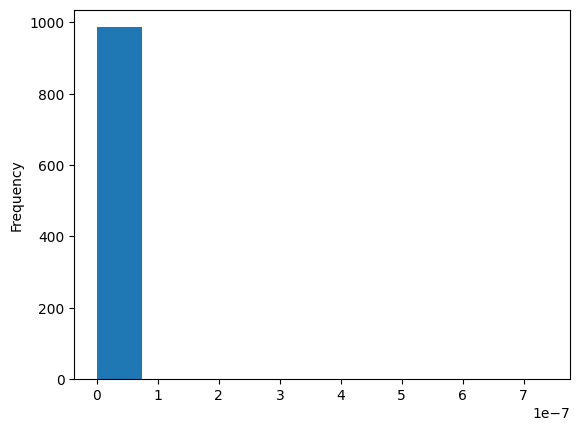

In [44]:
coint_matrix.p_value.plot(kind="hist")

In [67]:
(coint_matrix.p_value<0.001).sum()/coint_matrix["p_value"].count()

1.0

La totalidad de los p-valores están por debajo del 0.1%. Todo está cointegrado con todo.

## Test de estacionaridad

In [53]:
def adf_test(dataframe):
    """
    Perform the Augmented Dickey-Fuller (ADF) test for multiple data series and return p-values.

    Parameters:
    - dataframe (pd.DataFrame): The input DataFrame with multiple time series columns.
    - significance_level (float): The significance level for the ADF test (default is 0.05).

    Returns:
    - pd.DataFrame: A DataFrame containing p-values for each time series.
    """

    p_values = []

    for column in dataframe.columns:
        result = adfuller(dataframe[column])
        p_value = result[1]
        p_values.append(p_value)

    results_df = pd.DataFrame({'Variable': dataframe.columns, 'p_value': p_values})

    return results_df

In [54]:
adf_matrix=adf_test(df)
adf_matrix.head()

,Variable,p_value
0,^MERV_rets,0.000000e+00
1,^MERV_log_rets,0.000000e+00
2,^MERV_gk_vol,7.305657e-19
3,GGAL_rets,0.000000e+00
4,GGAL_log_rets,1.714681e-21


In [63]:
(adf_matrix.p_value>0.05).sum()

0

Todas las variables son estacionarias.